# Setup

In [1]:
DATA_VERSION = "2025-05-12"
DATA_FILE_NAME = f"consultation-documents-preprocessed-{DATA_VERSION}.parquet"
EXTRA_DOCUMENT_FEATURES_FILE_NAME = f"consultation-documents-features-{DATA_VERSION}.parquet"
EMBEDDINGS_FILE_NAME = (
    f"consultation-documents-embeddings-beginnings-openai-text-embedding-3-large-{DATA_VERSION}.parquet"
)

LANGUAGES = {
    "de",
    # "fr",
    # "it",
}

FROM_YEAR = 2000

MERGE_CLASSES = {
    # (classes, to, drop): replacement_class
    ("RESPONSE_FORM",): "SURVEY",
    ("DECISION", "PRESS_RELEASE"): "VARIOUS_TEXT",
}

INCLUDE_RULE_LABELS_IN_TRAINING = {
    "SYNOPTIC_TABLE",
    "LETTER",
    "RECIPIENT_LIST",
    "FINAL_REPORT",
}

CV_FOLDS = 5
TEST_SIZE = 0.1
RANDOM_STATE = 2718
USE_TEST_SET = True

In [2]:
%load_ext autoreload
%autoreload 2

import logging
import os
import pathlib
import sys
from typing import Any

import dotenv
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics
import sklearn.model_selection
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier  # noqa: F401
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler  # noqa: F401
from tqdm import tqdm

REPOSITORY_ROOT = (pathlib.Path().cwd() / ".." / "..").resolve()
sys.path.append(str(REPOSITORY_ROOT))

In [3]:
import demokratis_ml.models.document_types.preprocessing
from research.document_types import data_loading, document_title_rule_model
from research.lib import data_access, plotting, utils

In [4]:
logging.basicConfig(level=logging.INFO, format="%(levelname)s %(name)s: %(message)s")

In [5]:
dotenv.load_dotenv()

True

In [6]:
if os.environ.get("MLFLOW_TRACKING_USERNAME") and os.environ.get("MLFLOW_TRACKING_PASSWORD"):
    mlflow.set_tracking_uri("https://mlflow.ml1.demokratis.ch/")
else:
    logging.warning("MLflow credentials not found, will track locally.")
    mlflow.set_tracking_uri("sqlite:///mlruns.db")

mlflow.set_experiment("VM_document_type_classifier")

if run := mlflow.active_run():
    logging.warning("Run = %s is already active, closing it.", run.info.run_name)
    mlflow.end_run()
run = mlflow.start_run()
print("Starting run:", run.info.run_name)
mlflow.log_param("data_version", DATA_VERSION)
mlflow.log_param("input_file", DATA_FILE_NAME)
mlflow.log_param("extra_features_file", EXTRA_DOCUMENT_FEATURES_FILE_NAME)
mlflow.log_param("embeddings_file", EMBEDDINGS_FILE_NAME)
mlflow.log_param("languages", LANGUAGES)
mlflow.log_param("from_year", FROM_YEAR)
mlflow.log_param("cv_folds", CV_FOLDS)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("random_state", RANDOM_STATE)
mlflow.log_param("include_rule_labels_in_training", sorted(INCLUDE_RULE_LABELS_IN_TRAINING))
mlflow.log_param("merge_classes", MERGE_CLASSES)
;

Starting run: shivering-cat-248


''

In [7]:
mlflow.sklearn.autolog()
tqdm.pandas()

2025/05/12 11:31:49 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.5.2, but the installed version is 1.6.0. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


# Input data preparation

## Get all dataframes

In [8]:
PREPROCESSED_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / DATA_FILE_NAME
data_access.ensure_dataframe_is_available(PREPROCESSED_DATA_FILE)

FEATURES_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / EXTRA_DOCUMENT_FEATURES_FILE_NAME
data_access.ensure_dataframe_is_available(FEATURES_DATA_FILE)

EMBEDDINGS_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / EMBEDDINGS_FILE_NAME
data_access.ensure_dataframe_is_available(EMBEDDINGS_DATA_FILE)

INFO download_file_from_exoscale: Downloading dataframes/consultation-documents-preprocessed-2025-05-12.parquet from bucket demokratis-ml to /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-preprocessed-2025-05-12.parquet
INFO download_file_from_exoscale: Downloading dataframes/consultation-documents-features-2025-05-12.parquet from bucket demokratis-ml to /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-features-2025-05-12.parquet
INFO download_file_from_exoscale: Downloading dataframes/consultation-documents-embeddings-beginnings-openai-text-embedding-3-large-2025-05-12.parquet from bucket demokratis-ml to /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-embeddings-beginnings-openai-text-embedding-3-large-2025-05-12.parquet


In [9]:
df_docs_input, df_docs_test_external = data_loading.load_documents(
    document_file=PREPROCESSED_DATA_FILE,
    external_test_labels_file=REPOSITORY_ROOT / "research" / "document_types" / "ground_truth.xlsx",
    only_languages=LANGUAGES,
    starting_year=FROM_YEAR,
    include_rule_labels=INCLUDE_RULE_LABELS_IN_TRAINING,
)
df_docs_input

INFO document_title_rule_model: 0.00% of documents already have labels
INFO document_title_rule_model: Labelled 0.25% by rule: canton=<any>, title^=adressliste => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 2.26% by rule: canton=<any>, title^=adressatenliste => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.17% by rule: canton=<any>, title^=adressatenverzeichnis => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 1.02% by rule: canton=<any>, title^=vernehmlassungsadressaten => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.08% by rule: canton=<any>, title^=vernehmlassungsadressen => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.02% by rule: canton=<any>, title^=verzeichnis der anhörungsadressaten => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.01% by rule: canton=<any>, title^=liste der konsultationsadressatinnen und konsultationsadressaten => type=RECIPIENT_LIST
INFO document_title_rule_mod

,document_id,consultation_id,consultation_start_date,consultation_end_date,consultation_title,consultation_description,document_source_url,consultation_url,consultation_topics,consultation_internal_tags,...,organisation_name,political_body,latest_stored_file_id,document_source,consultation_topics_label_source,document_content_plain,stored_file_path,stored_file_mime_type,stored_file_hash,document_type_label_source
0,1,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,Bundesamt für Zoll und Grenzsicherheit,ch,7780,fedlex,manual,«$$e-seal» \n«$$QrCode» \n \n2021-… \n«%ASFF_Y...,2024/1/1/1CM3wffPbDu7fUxY1BS22e.pdf,application/pdf,b8816738ad84d806e55723a313613097bed2752f,explicit
3,4,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,Bundesamt für Zoll und Grenzsicherheit,ch,7783,fedlex,manual,Eidgenössisches Finanzdepartement EFD \nEidgen...,2024/1/4/1CM3wfhvda7QqrdPBrFGXj.pdf,application/pdf,d47bb05bc7f135a0b850702336ecca328f7dafce,explicit
6,7,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,Bundesamt für Zoll und Grenzsicherheit,ch,7786,fedlex,manual,Eidgenössisches Finanzdepartement EFD \nEidgen...,2024/1/7/1CM3wfjqyn9SRWiSzYWSf3.pdf,application/pdf,fdcb391ccf2efd9b56a446e39284e3cceab5e4eb,explicit
9,10,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,Bundesamt für Zoll und Grenzsicherheit,ch,7789,fedlex,manual,1. Oktober 2021 \n \n \n \n \nVerordnung des B...,2024/1/10/1CM3wfmi6ep9UK6E5T4bNu.pdf,application/pdf,b631111878a9eea5ae89bdc7ce85d86c609856a3,explicit
12,13,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,Bundesamt für Zoll und Grenzsicherheit,ch,7792,fedlex,manual,Eidgenössisches Finanzdepartement EFD \nEidgen...,2024/1/13/1CM3wfoMZEhmu1hg9dbkvS.pdf,application/pdf,aa8dee571dc5bd912ba0adcc034dbda45f0b62c9,explicit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53250,55109,5125,2025-04-25,2025-08-25,Parlamentarische Initiative der Kommission für...,Die parlamentarische Initiative verlangt eine ...,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/8a3yue9h,"[administration, law, political_system]","[{'created_at': 2025-05-08 11:01:49, 'name': '...",...,Regierungsrat des Kantons Aargau,ag,46123,openparldata,manual,\nSynopse Beilage 2 zum Anhörungsbericht \n \...,2025/5125/55109/1CNuwpXZStvtYZCDHdfaS2.pdf,application/pdf,f765b257587b080842248e6d8c14af93dbf62779,explicit
53251,55110,5125,2025-04-25,2025-08-25,Parlamentarische Initiative der Kommission für...,Die parlamentarische Initiative verlangt eine ...,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/8a3yue9h,"[administration, law, p

In [10]:
df_docs_test_external

,document_id,consultation_id,consultation_start_date,consultation_end_date,consultation_title,consultation_description,document_source_url,consultation_url,consultation_topics,consultation_internal_tags,...,political_body,latest_stored_file_id,document_source,consultation_topics_label_source,document_content_plain,stored_file_path,stored_file_mime_type,stored_file_hash,document_type_label_source,document_type
38521,38522,2317,2021-09-08,2021-12-09,Materielle und formelle Revision des Gebührenr...,,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/xnyvgkgk,"[economics, finance]",[],...,ag,<NA>,openparldata,openparldata,Synopse Beilage 1 zum Anhörungsbericht \n \nA...,None,None,None,external_test,SYNOPTIC_TABLE
38570,38571,2322,2022-02-20,2022-04-21,Anpassung des Richtplans; Verminderung der Fru...,,https://www.ag.ch/media/kanton-aargau/bvu/raum...,https://www.demokratis.ch/vernehmlassung/84ssk4vc,"[energy, environment, spatial_planning]",[],...,ag,<NA>,openparldata,openparldata,Axpo Power AG | Hydroenergie & Biomasse \n\nPa...,None,None,None,external_test,VARIOUS_TEXT
38660,38684,2339,2012-01-06,2012-02-06,Gemeinde Gontenschwil; Anpassung des Richtplans,,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/fs257a7u,[spatial_planning],[],...,ag,40174,openparldata,openparldata,j:\vernehmlassungen\vernehmlassungen\kanton\rp...,2024/2339/38684/1CMHFvwchtwhvVAGhERwUx.pdf,application/pdf,486e5734ef73a2feb2234b86eb2ccda62b3f43d0,external_test,REPORT
38664,38688,2340,2012-01-11,2012-04-13,eHealth; IDAG und des Gesundheitsgesetz; Teilr...,Der Bund wird voraussichtlich im Jahr 2015 ode...,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/69q4yzws,"[health, it]","[{'created_at': 2025-01-25 14:10:50, 'name': '...",...,ag,40171,openparldata,manual,Departement \nGesundheit und Soziales \nVorste...,2024/2340/38688/1CMHFvpmT837scS6K98QfL.pdf,application/pdf,9ef01b766efdc253cde3b01fd4752b99e1c63855,external_test,LETTER
38747,38771,2362,2012-12-10,2013-03-08,Gemeinde Würenlos; Anpassung des Richtplans,,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/nnuj5gx8,[spatial_planning],[],...,ag,<NA>,openparldata,openparldata,Gemeinde Würenlos Kanton Aargau \n___________...,None,None,None,external_test,REPORT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50498,52074,4835,2024-08-16,2024-11-11,Änderung des Finanzausgleichsgesetzes,"Der Regierungsrat hat in Aussicht gestellt, na...",https://sh.ch/CMS/get/file/f6cad1a9-895e-40d7-...,https://www.demokratis.ch/vernehmlassung/vwp33sb5,"[administration, public_finance, security]","[{'created_at': 2025-04-15 11:52:34, 'name': '...",...,sh,5796,openparldata,manual,Kanton Schaffhausen\nMedienkonferenz\nÄnderung...,2024/4835/52074/1CM2Lx6kBnu82sM9EBj2wc.pdf,application/pdf,f6119766677a6ef503956c9ef69ac108876f778d,external_test,VARIOUS_TEXT
50816,52424,4886,2024-09-13,2024-10-15,Änderung der Verordnung zum Einführungsgesetz ...,"Der Regierungsrat plant, die monatlichen Kinde...",https://zg.ch/dam/jcr:95397bc7-9729-4e66-9c3c-...,https://www.demokratis.ch/vernehmlassung/nmu3kfpv,"[economics, public_finance, social]","[{'created_at': 2025-04-08 13:47:48, 'name': '...",...,zg,6064,openparldata,manual,Amt für Gesundheit_3 \n \nÄnderung der Verord...,2024/4886/52424/1CM2MAHFJQhCLbd65xquDU.pdf,application/pdf,8b6a8ae3483311da1145da08d7a5f1d3b4e8a0f8,external_test,RESPONSE_FORM
50935,52559,4901,2024-09-19,2024-10-31,Revision des Gesetzes über den Fristenlauf (FriG),Der Bund nimmt auf Anfang 2025 eine Änderung b...,https://www.ai.ch/politik/standeskommission/ka...,https://www.demokratis.ch/vernehmlassung/w4rqwc8a,"[administration, communications, law]","[{'created_at': 2024-10-16 10:51:54, 'name': '...",...,ai,6191,openparldata,manual,AI 013.25-27.71.5-1211726 1-2 \nLandammann un...,2024/4901/52559/1CM2MDcYW7HDAiDmhdErv4.pd

In [11]:
df_features = pd.read_parquet(FEATURES_DATA_FILE)
df_features

,,contains_table_on_first_page,count_pages,count_tables,count_pages_containing_tables,count_images,count_pages_containing_images,average_page_aspect_ratio
document_id,stored_file_hash,,,,,,,
1,b8816738ad84d806e55723a313613097bed2752f,False,26,0.0,0.0,0.0,0.0,0.704898
4,d47bb05bc7f135a0b850702336ecca328f7dafce,False,6,0.0,0.0,1.0,1.0,0.707098
7,fdcb391ccf2efd9b56a446e39284e3cceab5e4eb,False,2,0.0,0.0,1.0,1.0,0.707098
10,b631111878a9eea5ae89bdc7ce85d86c609856a3,False,15,0.0,0.0,13.0,6.0,0.707098
13,aa8dee571dc5bd912ba0adcc034dbda45f0b62c9,False,2,0.0,0.0,1.0,1.0,0.707098
...,...,...,...,...,...,...,...,...
55130,4594f19f464aa23776402aeb4d515ef653541cfa,False,32,53.0,29.0,0.0,0.0,0.706956
55131,cde1fab7864d0f65539d282785ac521ac9511806,False,2,0.0,0.0,0.0,0.0,0.707104
55132,5f3a3bac00c1bb44f4a92e41f7b02cfefb39429c,True,3,3.0,3.0,0.0,0.0,1.414218


In [12]:
df_embeddings = pd.read_parquet(EMBEDDINGS_DATA_FILE)
df_embeddings

,embedding
document_id,
1,"[0.01030252780765295, -0.014312159270048141, -..."
4,"[0.011395552195608616, 0.0014780974015593529, ..."
7,"[-0.005767590366303921, 0.002646328415721655, ..."
10,"[0.019797369837760925, -0.00907826703041792, -..."
13,"[-0.001758241094648838, 0.002000046195462346, ..."
...,...
55130,"[0.005953548941761255, -0.017270581796765327, ..."
55131,"[-0.028964143246412277, 0.016269221901893616, ..."
55132,"[-0.04354700818657875, 0.012121095322072506, -..."


## Preprocess

In [13]:
print("df_input:")
df_input = demokratis_ml.models.document_types.preprocessing.create_input_dataframe(
    df_docs_input,
    df_extra_features=df_features,
    df_embeddings=df_embeddings,
    class_merges=MERGE_CLASSES,
)
print("df_test_external:")
df_test_external = demokratis_ml.models.document_types.preprocessing.create_input_dataframe(
    df_docs_test_external,
    df_extra_features=df_features,
    df_embeddings=df_embeddings,
    class_merges=MERGE_CLASSES,
)

INFO root: Dropping 1042 documents (5.9%) with empty texts


df_input:


INFO root: 2508 rows were lost due to missing features. Remaining rows: 14163. 11 columns were added.
INFO root: 0 rows were lost due to missing embeddings. Remaining rows: 14163. 1 columns were added.
INFO root: Dropping 7 documents (5.6%) with empty texts
INFO root: 53 rows were lost due to missing features. Remaining rows: 66. 11 columns were added.
INFO root: 0 rows were lost due to missing embeddings. Remaining rows: 66. 1 columns were added.


df_test_external:


## Split

### Set aside a test set

In [14]:
splitter = sklearn.model_selection.StratifiedShuffleSplit(
    n_splits=1,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

train_index, test_index = next(splitter.split(X=df_input, y=df_input["document_type"]))

In [15]:
df_input_train = df_input.iloc[train_index]
df_input_test = df_input.iloc[test_index]

mlflow.log_param("train_samples_count", len(df_input_train))
mlflow.log_param("test_samples_count", len(df_input_test))

print("Train:", df_input_train.shape)
print("Test:", df_input_test.shape)

Train: (12746, 36)
Test: (1417, 36)


### Prepare a cross-validation splitter

In [16]:
cv_splitter = sklearn.model_selection.StratifiedKFold(
    n_splits=CV_FOLDS,
    shuffle=True,
    random_state=RANDOM_STATE,
)

# Data exploration

## Data representation

In [17]:
print("df_input labels:")
df_input.groupby("document_type_label_source")["document_type"].value_counts()

df_input labels:


document_type_label_source  document_type 
explicit                    DRAFT             2896
                            LETTER            2645
                            REPORT            2334
                            RECIPIENT_LIST    1783
                            FINAL_REPORT      1688
                            OPINION            786
                            VARIOUS_TEXT       642
                            SYNOPTIC_TABLE     271
                            SURVEY              51
                            DECISION             0
                            LINK                 0
                            PRESS_RELEASE        0
                            RESPONSE_FORM        0
rule                        LETTER             468
                            RECIPIENT_LIST     290
                            SYNOPTIC_TABLE     264
                            FINAL_REPORT        45
                            DECISION             0
                            DRAFT      

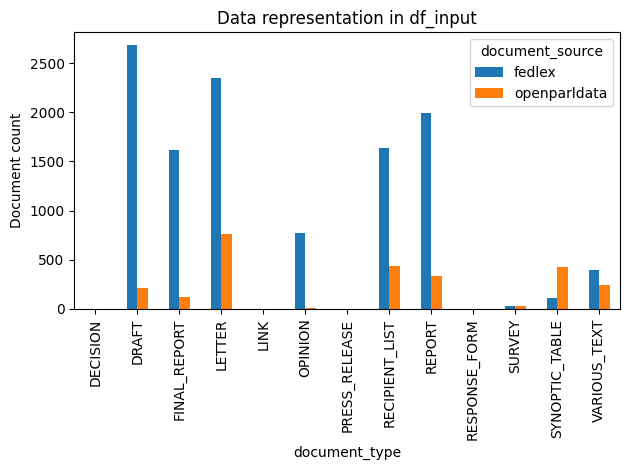

document_source,fedlex,openparldata
document_type,,
DECISION,0,0
DRAFT,2681,215
FINAL_REPORT,1614,119
LETTER,2350,763
LINK,0,0
OPINION,774,12
PRESS_RELEASE,0,0
RECIPIENT_LIST,1642,431
REPORT,1997,337


In [18]:
repr_table = df_input.pivot_table(
    index="document_type", columns="document_source", aggfunc="size", fill_value=0, observed=False
)
display(
    plotting.plot_and_log(
        repr_table.plot,
        "data_representation.png",
        title="Data representation in df_input",
        kind="bar",
        ylabel="Document count",
    )
)
display(repr_table)

## Extra features

In [19]:
print("contains_salutation:")
df_input.pivot_table(
    index="document_type",
    columns="document_source",
    values="contains_salutation",
    aggfunc="mean",
    fill_value=0,
    observed=False,
)

contains_salutation:


document_source,fedlex,openparldata
document_type,,
DRAFT,0.001119,0.000000
FINAL_REPORT,0.003717,0.117647
LETTER,0.985106,0.979030
OPINION,0.746770,0.750000
RECIPIENT_LIST,0.000000,0.000000
REPORT,0.013020,0.041543
SURVEY,0.000000,0.074074
SYNOPTIC_TABLE,0.000000,0.000000
VARIOUS_TEXT,0.015075,0.000000


### Keyword-like features

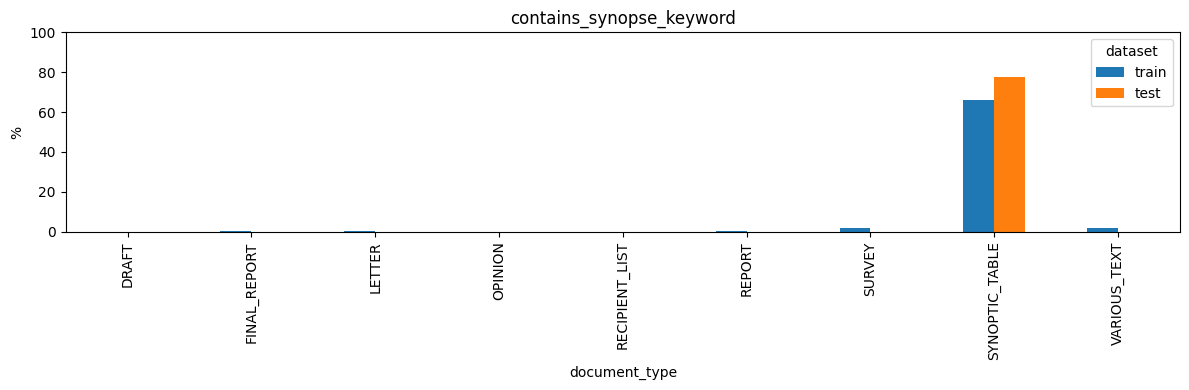

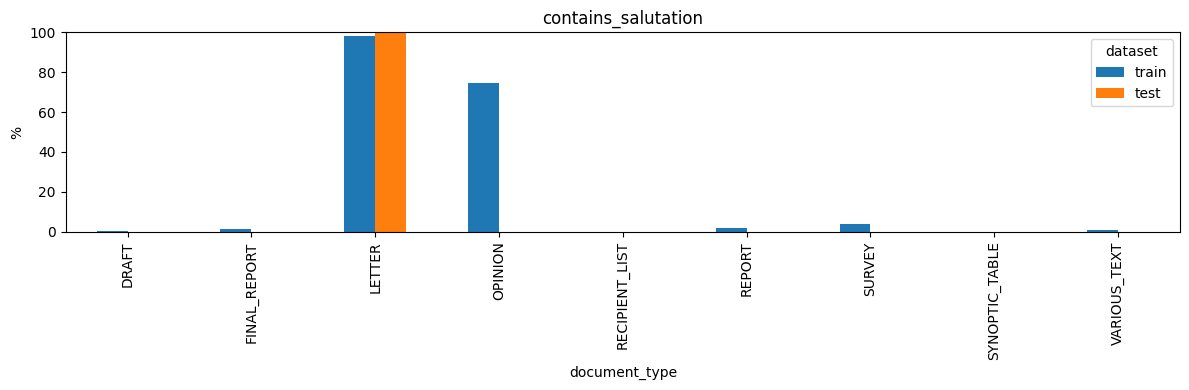

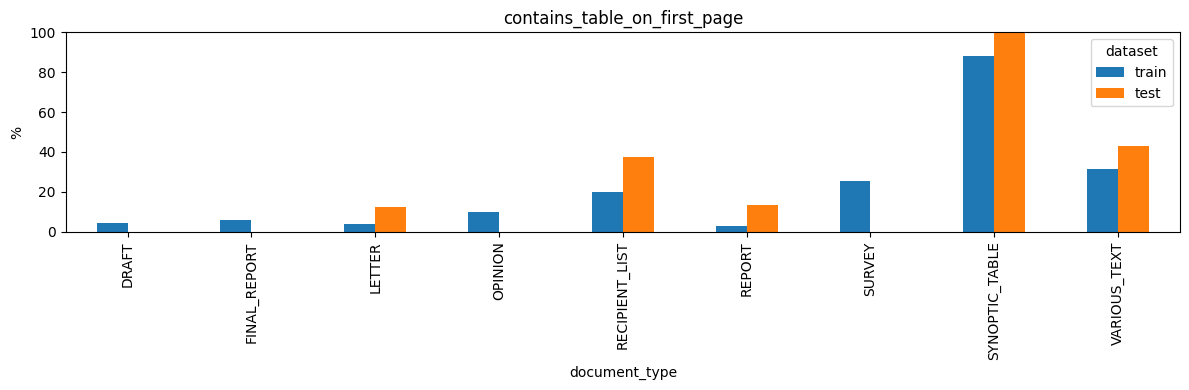

In [20]:
def plot_binary_feature_across_document_types(df_train: pd.DataFrame, df_test: pd.DataFrame, feature_name: str) -> None:
    df = pd.concat(
        [
            df_train[["document_type", feature_name]].assign(dataset="train"),
            df_test[["document_type", feature_name]].assign(dataset="test"),
        ],
        axis=0,
    )
    pivot_table = df.pivot_table(
        index="document_type",
        columns="dataset",
        values=feature_name,
        aggfunc=lambda x: 100 * x.mean(),
        fill_value=0,
        observed=False,
    )
    pivot_table = pivot_table[["train", "test"]]  # Ensure "train" comes first
    pivot_table.plot(
        kind="bar",
        figsize=(12, 4),
        title=feature_name,
        ylabel="%",
        ylim=(0, 100),
    )
    plt.tight_layout()
    plt.show()


plot_binary_feature_across_document_types(df_input, df_test_external, "contains_synopse_keyword")
plot_binary_feature_across_document_types(df_input, df_test_external, "contains_salutation")
plot_binary_feature_across_document_types(df_input, df_test_external, "contains_table_on_first_page")

In [21]:
def plot_feature_distribution_across_document_types(
    df_train: pd.DataFrame, df_test: pd.DataFrame, feature_name: str, clip_y: None | tuple[int, int] = None
) -> None:
    plt.figure(figsize=(14, 5))
    df = pd.concat(
        [
            df_train[["document_type", feature_name]].assign(dataset="train"),
            df_test[["document_type", feature_name]].assign(dataset="test"),
        ],
        axis=0,
    )
    ax = sns.violinplot(
        data=df,
        x="document_type",
        y=feature_name,
        hue="dataset",
        order=sorted(df["document_type"].unique()),
        # inner="box",  # Show boxplot inside violin
        inner=None,  # Show only violin
        split=True,
        linewidth=0.1,
    )
    plt.xticks(rotation=90)
    if clip_y:
        sample = df[feature_name].dropna()
        ax.set_ylim(*np.percentile(sample, clip_y))
        plt.title(f"{feature_name} (clipped to {clip_y[0]}-{clip_y[1]}th percentile)")
    else:
        plt.title(feature_name)
    plt.tight_layout()
    plt.show()

### Page count, aspect ratio

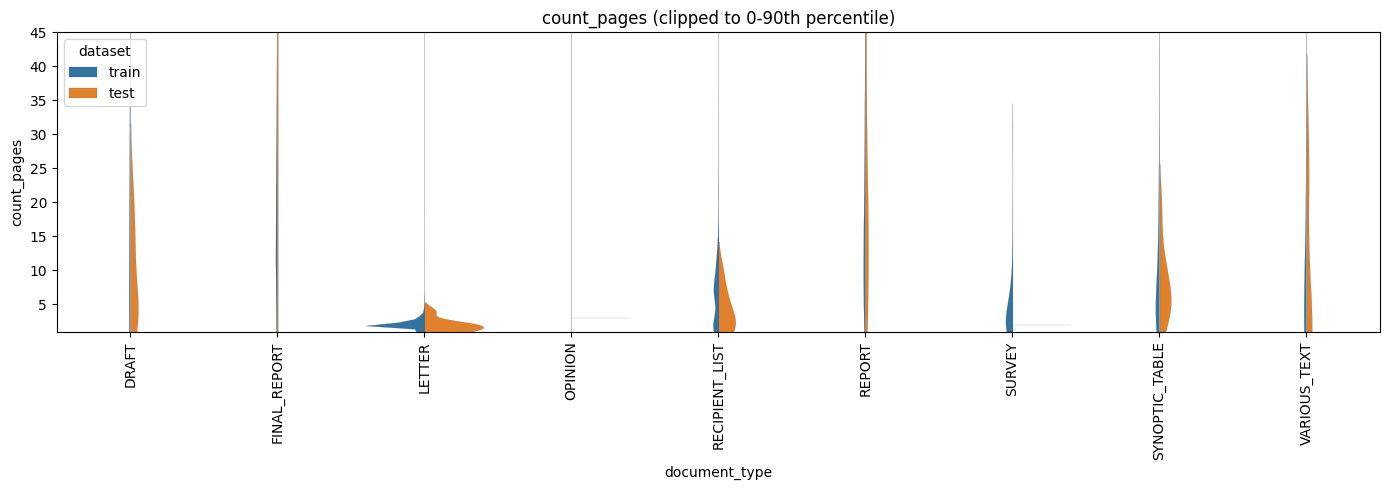

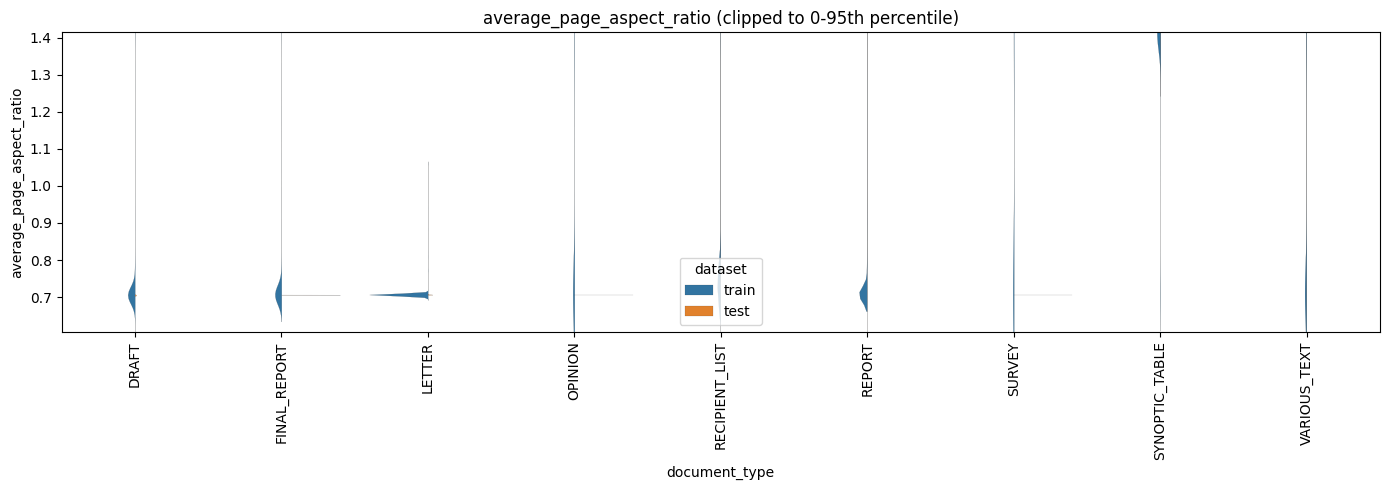

In [22]:
plot_feature_distribution_across_document_types(df_input, df_test_external, "count_pages", clip_y=(0, 90))
plot_feature_distribution_across_document_types(df_input, df_test_external, "average_page_aspect_ratio", clip_y=(0, 95))

In [23]:
pd.concat([df_input.assign(dataset="train"), df_test_external.assign(dataset="test")], axis=0).pivot_table(
    index="document_type",
    columns="dataset",
    values="count_pages",
    aggfunc=["mean", "std"],
    fill_value=0,
    observed=False,
)

mean                    std            
dataset              test       train       test       train
document_type                                               
DRAFT            9.307692   15.172307   7.238607   85.541266
FINAL_REPORT    53.750000   26.749567  64.912120   43.820699
LETTER           1.875000    2.165114   0.991031    1.411841
OPINION          3.000000  363.821883   0.000000  737.321419
RECIPIENT_LIST   4.000000    7.018813   3.207135    5.403161
REPORT          25.400000   24.734790  20.725416   30.471905
SURVEY           2.000000    4.450980   0.000000    5.037117
SYNOPTIC_TABLE   7.777778   10.618692   5.166667   13.306261
VARIOUS_TEXT     8.000000   14.475078  11.633286   27.578511

In [24]:
pd.concat([df_input.assign(dataset="train"), df_test_external.assign(dataset="test")], axis=0).pivot_table(
    index="document_type",
    columns="dataset",
    values="average_page_aspect_ratio",
    aggfunc=["mean", "std"],
    fill_value=0,
    observed=False,
)

mean                 std          
dataset             test     train      test     train
document_type                                         
DRAFT           0.705678  0.729689  0.000990  0.113698
FINAL_REPORT    0.706969  0.730249  0.000024  0.112165
LETTER          0.707218  0.707840  0.000446  0.014637
OPINION         0.706997  0.826329  0.000000  0.251026
RECIPIENT_LIST  0.972260  0.768568  0.366096  0.179527
REPORT          0.774360  0.726101  0.203589  0.093581
SURVEY          0.707098  0.870782  0.000000  0.296478
SYNOPTIC_TABLE  1.401125  1.368568  0.040129  0.166872
VARIOUS_TEXT    1.016457  0.868729  0.388462  0.292862

### Tables

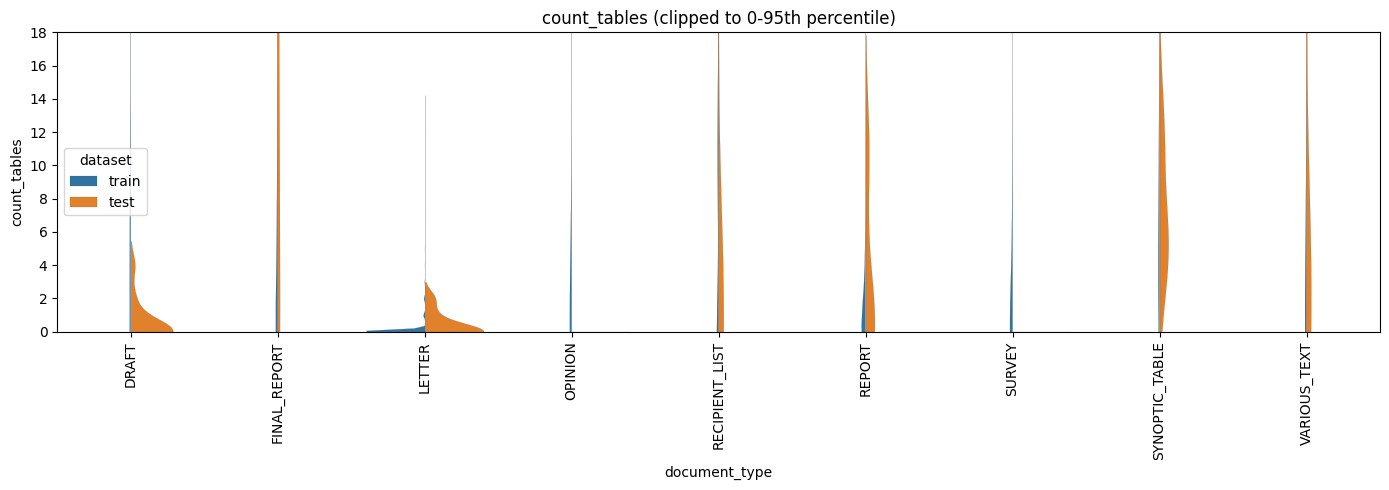

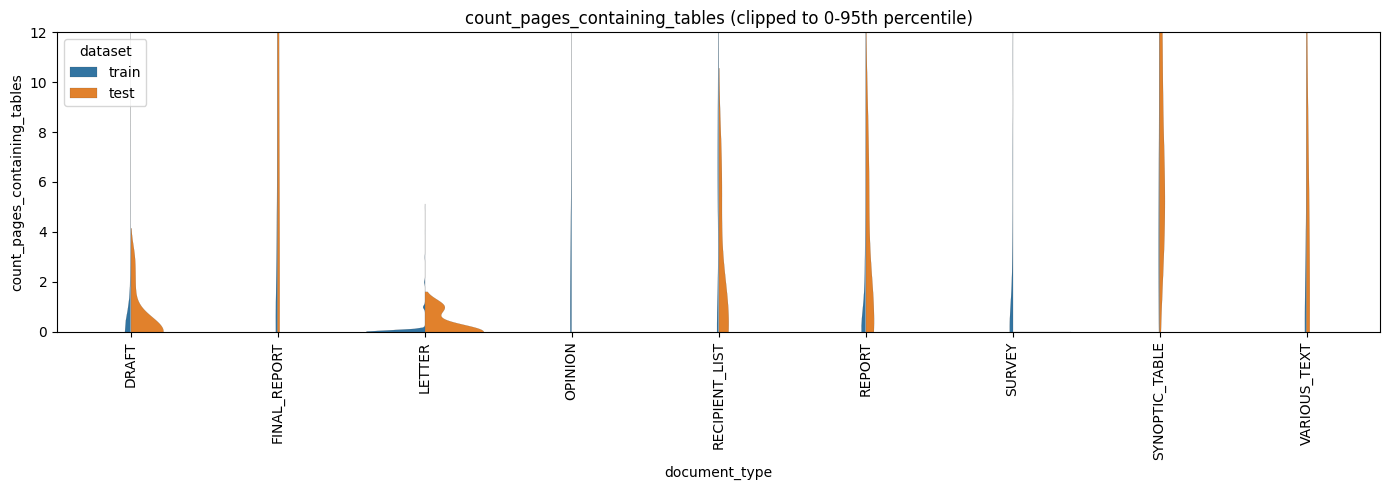

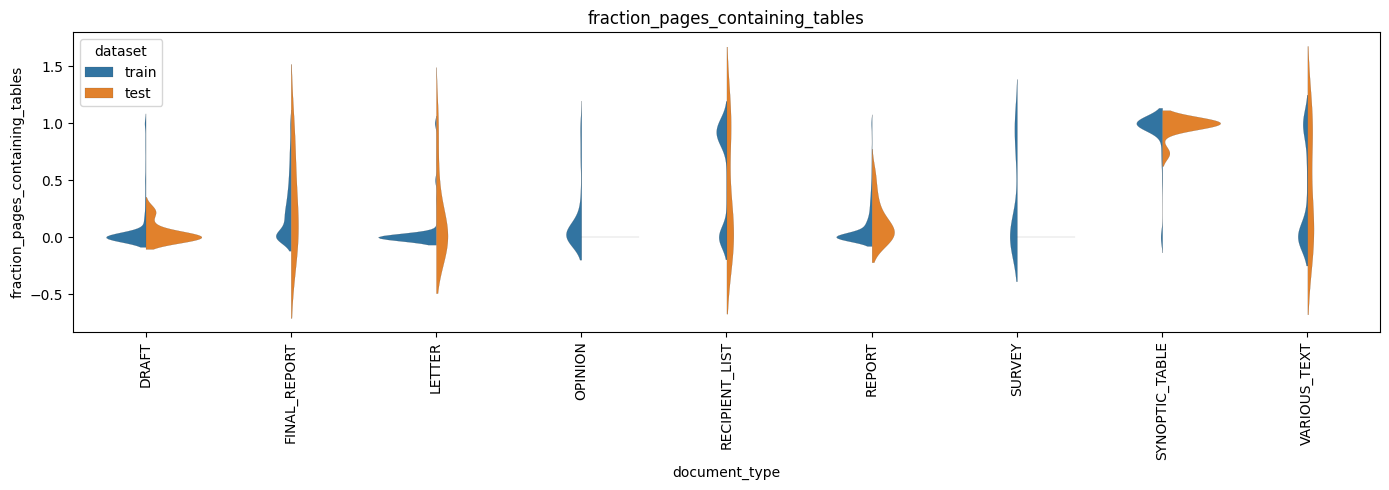

In [25]:
plot_feature_distribution_across_document_types(df_input, df_test_external, "count_tables", clip_y=(0, 95))
plot_feature_distribution_across_document_types(
    df_input, df_test_external, "count_pages_containing_tables", clip_y=(0, 95)
)
plot_feature_distribution_across_document_types(df_input, df_test_external, "fraction_pages_containing_tables")

### Images

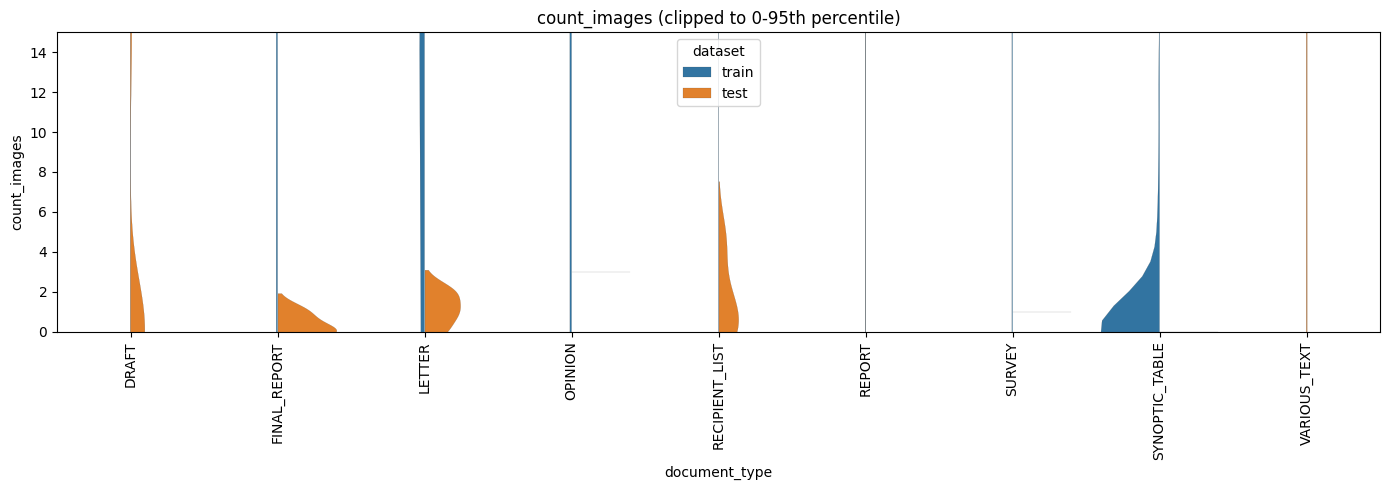

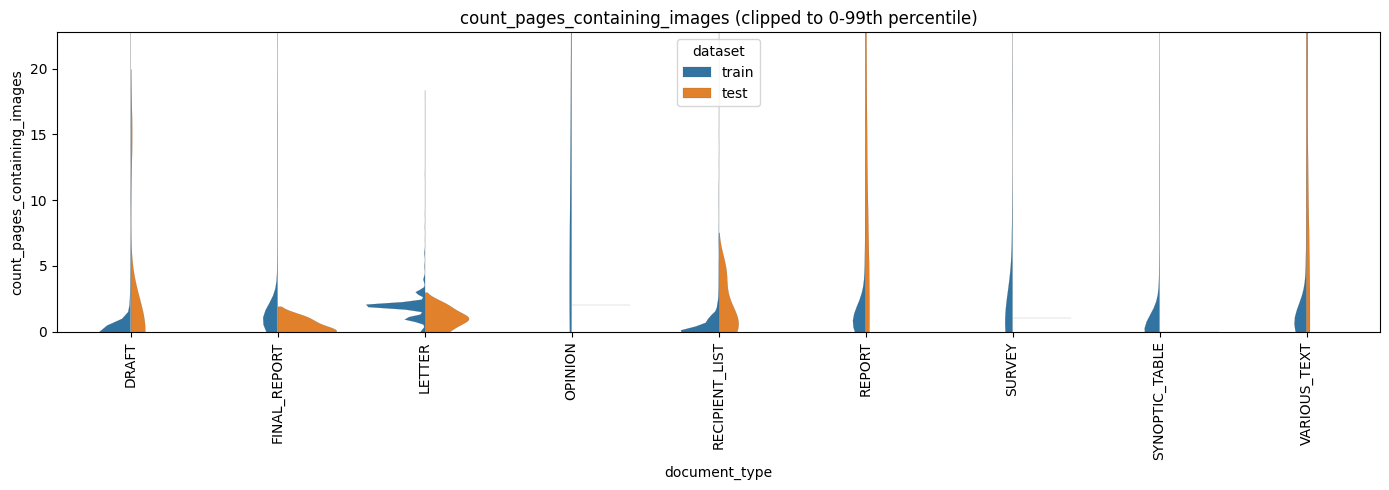

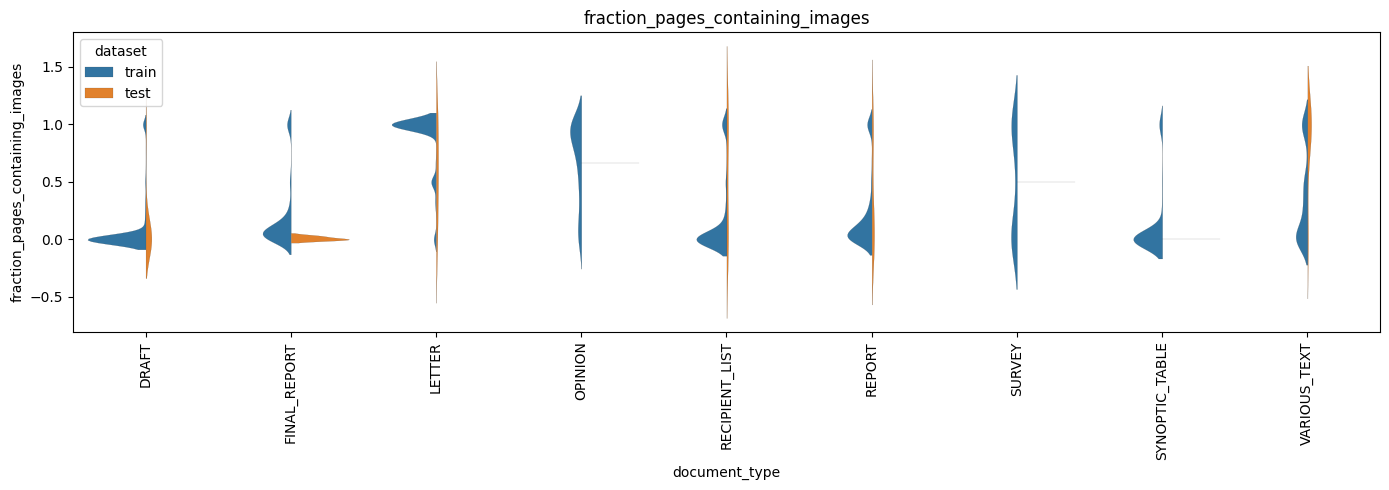

In [26]:
plot_feature_distribution_across_document_types(df_input, df_test_external, "count_images", clip_y=(0, 95))
plot_feature_distribution_across_document_types(
    df_input, df_test_external, "count_pages_containing_images", clip_y=(0, 99)
)
plot_feature_distribution_across_document_types(df_input, df_test_external, "fraction_pages_containing_images")

# Classification

In [27]:
extra_feature_columns = [
    "contains_synopse_keyword",  # bool: whether the beginning of the document contains the word "synopse"
    "contains_salutation",  # bool: whether the beginning of the document contains a formal German letter greetings
    "contains_table_on_first_page",  # bool: whether the first page contains a table
    "count_pages",  # int: number of pages in the document
    "count_pages_containing_images",  # int: number of pages containing images (for documents <= 50 pages)
    "count_pages_containing_tables",  # int: number of pages containing tables (for documents <= 50 pages)
    "average_page_aspect_ratio",  # float: average aspect ratio of pages (width / height) (for documents <= 50 pages)
    # Removed: train/test distributions don't match well:
    #    "fraction_pages_containing_images",  # float: count_pages_containing_images / count_pages
    #    "fraction_pages_containing_tables",  # float: count_pages_containing_tables / count_pages
]
extra_categorical_feature_columns = [
    # "political_body",
    # "document_source",
]

mlflow.log_param("extra_feature_columns", sorted(extra_feature_columns))
mlflow.log_param("extra_categorical_feature_columns", sorted(extra_categorical_feature_columns))


def create_matrices(df: pd.DataFrame) -> tuple[np.ndarray, pd.Series]:
    embeddings = np.vstack(df["embedding"])
    x = np.hstack(
        (
            embeddings,
            df[extra_feature_columns].fillna(0),
            df[extra_categorical_feature_columns],
        )
    )
    y = df["document_type"]
    assert x.shape[0] == y.shape[0]
    return x, y


X_train, y_train = create_matrices(df_input_train)
X_test, y_test = create_matrices(df_input_test)
X_test_external, y_test_external = create_matrices(df_test_external)

print("train", X_train.shape)
print("test", X_test.shape)
print("test_external", X_test_external.shape)

train (12746, 3079)
test (1417, 3079)
test_external (66, 3079)


In [28]:
embedding_dimension = df_embeddings["embedding"].iloc[0].shape[0]

i_embeddings = 0
i_extra_features = i_embeddings + embedding_dimension
i_categorical_features = i_extra_features + len(extra_feature_columns)
assert i_categorical_features + len(extra_categorical_feature_columns) == X_train.shape[1]


def create_classifier() -> Pipeline:
    pca_step = None  # If this is set in the pipeline below, we'll log the number of components to MLflow.
    pipeline = make_pipeline(
        ColumnTransformer(
            [
                (
                    "embeddings",
                    make_pipeline(
                        StandardScaler(),
                        pca_step := PCA(n_components=20, random_state=RANDOM_STATE),
                    ),
                    slice(i_embeddings, i_extra_features),
                ),
                (
                    "extra_features",
                    make_pipeline(
                        StandardScaler(),
                    ),
                    slice(i_extra_features, i_categorical_features),
                ),
                # (
                #     "categorical_features",
                #     make_pipeline(
                #         OneHotEncoder(
                #             sparse_output=False,
                #             categories=[
                #                 # list(schemata.CANTON_CODES | {schemata.FEDERAL_CODE}),
                #                 # ["fedlex", "openparldata"],
                #             ],
                #         ),
                #         StandardScaler(),
                #     ),
                #     slice(i_categorical_features, None),
                # ),
            ]
        ),
        LogisticRegression(max_iter=2000),
        # GradientBoostingClassifier(random_state=RANDOM_STATE),
    )
    if pca_step is not None:
        mlflow.log_param("pca_n_components", pca_step.get_params()["n_components"])
    return pipeline


classifier = create_classifier()
classifier

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('embeddings',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=20,
                                                                       random_state=2718))]),
                                                  slice(0, 3072, None)),
                                                 ('extra_features',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  slice(3072, 3079, None))])),
                ('logisticregression', LogisticRegression(max_iter=2000))])

In [29]:
def explained_variance_scorer(pipeline: Pipeline, X: Any, y: Any = None) -> np.float64:
    try:
        pca = pipeline.named_steps["pca"]
    except KeyError:
        try:
            pca = pipeline.named_steps["columntransformer"].named_transformers_["embeddings"].named_steps["pca"]
        except (KeyError, AttributeError):
            return np.nan
    explained_variance = np.sum(pca.explained_variance_ratio_)
    return explained_variance


scoring = {
    "precision": "precision_weighted",
    "recall": "recall_weighted",
    "f1": "f1_weighted",
    "pca_explained_variance": explained_variance_scorer,
    "accuracy": "accuracy",
    "top_k_accuracy": "top_k_accuracy",
    # "top_k_accuracy": sklearn.metrics.make_scorer(sklearn.metrics.top_k_accuracy_score, k=3),
}

scores_docs = sklearn.model_selection.cross_validate(
    classifier,
    X=X_train,
    y=y_train,
    cv=cv_splitter,
    scoring=scoring,
)
scores_docs

{'fit_time': array([6.55240393, 7.09884787, 7.44445586, 6.87516022, 7.26357198]),
 'score_time': array([0.34003901, 0.36872506, 0.38351011, 0.3347919 , 0.41820598]),
 'test_precision': array([0.91413519, 0.91225759, 0.92103161, 0.91882689, 0.91503876]),
 'test_recall': array([0.91843137, 0.91486858, 0.92428403, 0.92114555, 0.91879168]),
 'test_f1': array([0.91442144, 0.91260602, 0.92218227, 0.91950102, 0.91596918]),
 'test_pca_explained_variance': array([0.41304422, 0.41411487, 0.41356563, 0.41275241, 0.4134738 ]),
 'test_accuracy': array([0.91843137, 0.91486858, 0.92428403, 0.92114555, 0.91879168]),
 'test_top_k_accuracy': array([0.96235294, 0.959592  , 0.96939976, 0.97136132, 0.96822283])}

## Evaluation of the cross-validation

In [30]:
utils.log_metrics(
    **{k.replace("test_", "cv_"): np.round(np.mean(v), 4) for k, v in scores_docs.items() if k.startswith("test_")}
)

{'cv_accuracy': 0.9195,
 'cv_f1': 0.9169,
 'cv_pca_explained_variance': 0.4134,
 'cv_precision': 0.9163,
 'cv_recall': 0.9195,
 'cv_top_k_accuracy': 0.9662}


### Use subsets of the training set to re-train and evaluate. This gives us a single model to run reports on. 

In [31]:
cv_test_splitter = sklearn.model_selection.StratifiedShuffleSplit(
    n_splits=1,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

cv_train_index, cv_test_index = next(cv_test_splitter.split(X=X_train, y=y_train))

X_cv_train = X_train[cv_train_index]
y_cv_train = y_train.iloc[cv_train_index]
X_cv_test = X_train[cv_test_index]
y_cv_test = y_train.iloc[cv_test_index]

In [32]:
classifier.fit(X_cv_train, y_cv_train)
cv_test_predictions = classifier.predict(X_cv_test)

2025/05/12 11:33:37 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/05/12 11:33:52 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


                precision    recall  f1-score   support

         DRAFT       0.88      0.90      0.89       261
  FINAL_REPORT       0.95      0.93      0.94       156
        LETTER       0.99      0.99      0.99       280
       OPINION       0.93      0.90      0.91        71
RECIPIENT_LIST       0.98      0.99      0.99       187
        REPORT       0.87      0.91      0.89       210
        SURVEY       0.75      0.75      0.75         4
SYNOPTIC_TABLE       0.85      0.94      0.89        48
  VARIOUS_TEXT       0.67      0.45      0.54        58

      accuracy                           0.92      1275
     macro avg       0.87      0.86      0.87      1275
  weighted avg       0.92      0.92      0.92      1275



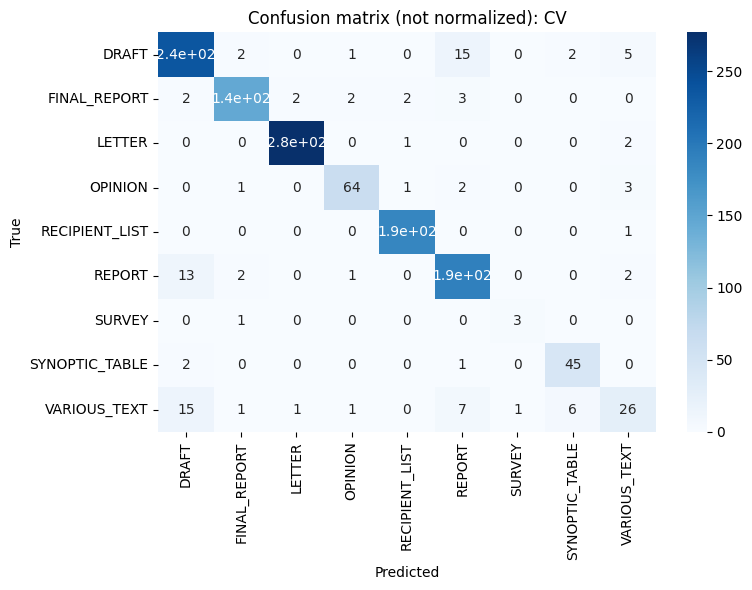

In [33]:
report = sklearn.metrics.classification_report(y_cv_test, cv_test_predictions, zero_division=np.nan)
mlflow.log_text(report, "cv_classification_report.txt")
print(report)
cm = plotting.plot_confusion_matrix_heatmap(y_cv_test, cv_test_predictions, title="CV")
mlflow.log_figure(cm, "cv_confusion_matrix.png")
display(cm)

### Feature importance

In [34]:
# explainer = shap.Explainer(classifier)  # .named_steps["logisticregression"])
# shap_values = explainer(X_cv_test)

# # visualize the first prediction's explanation
# shap.plots.waterfall(shap_values[0])


# def get_shap_values_for_complex_pipeline(pipeline, X_test):
#     # Extract preprocessing steps
#     column_transformer = pipeline.named_steps["columntransformer"]
#     classifier = pipeline.named_steps["logisticregression"]

#     # Transform a small batch of data for initialization
#     background_indices = np.random.choice(X_test.shape[0], 100, replace=False)
#     background_data = column_transformer.transform(X_test[background_indices])

#     # Create explainer with both model and background data
#     explainer = shap.KernelExplainer(classifier.predict, background_data)

#     # Transform the full test data
#     transformed_data = column_transformer.transform(X_test)

#     # Get SHAP values
#     shap_values = explainer.shap_values(transformed_data)

#     return shap_values


# Usage
# shap_values = get_shap_values_for_complex_pipeline(classifier, X_cv_test)
# shap_values


In [35]:
# importances = pd.Series(
#     classifier.named_steps["gradientboostingclassifier"].feature_importances_,
#     index=[f"embedding_{i:02d}" for i in range(20)] + extra_feature_columns,
# )
# importances.sort_values(ascending=False)

***

## Evaluation on the test set (USE SPARINGLY)

2025/05/12 11:34:01 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/05/12 11:34:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


                precision    recall  f1-score   support

         DRAFT       0.92      0.94      0.93       290
  FINAL_REPORT       0.94      0.96      0.95       173
        LETTER       0.99      1.00      0.99       311
       OPINION       0.95      0.90      0.92        79
RECIPIENT_LIST       0.99      1.00      1.00       207
        REPORT       0.90      0.93      0.92       234
        SURVEY       0.50      0.60      0.55         5
SYNOPTIC_TABLE       0.89      0.87      0.88        54
  VARIOUS_TEXT       0.67      0.45      0.54        64

      accuracy                           0.94      1417
     macro avg       0.86      0.85      0.85      1417
  weighted avg       0.93      0.94      0.93      1417



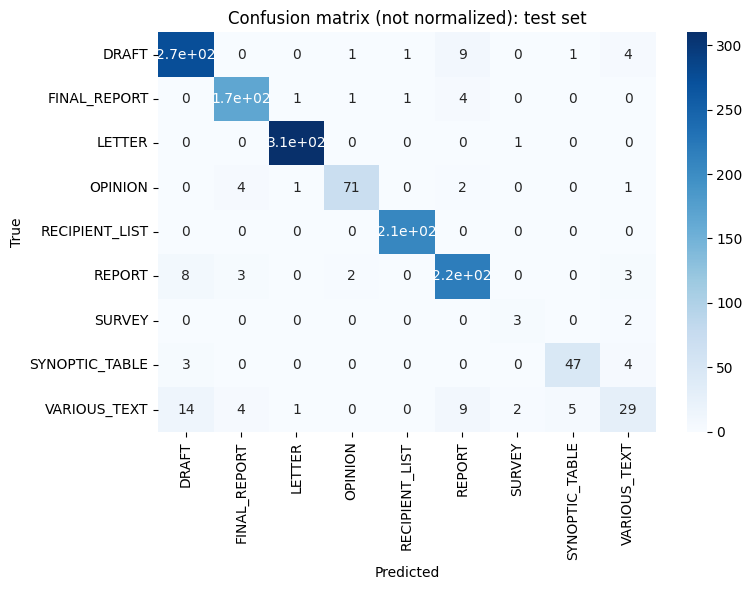

{'test_accuracy': 0.9351,
 'test_f1': 0.9322,
 'test_precision': 0.9317,
 'test_recall': 0.9351,
 'test_top_k_accuracy': 0.9725}


In [36]:
if USE_TEST_SET:
    # Training & OOS predictions
    classifier_test = create_classifier()
    classifier_test.fit(X_train, y_train)
    test_ground_truth_docs = y_test
    test_predictions_docs = classifier_test.predict(X_test)

    # Classification report
    report = sklearn.metrics.classification_report(
        test_ground_truth_docs,
        test_predictions_docs,
        zero_division=np.nan,
    )
    mlflow.log_text(report, "test_classification_report.txt")
    print(report)

    # Confusion matrix
    cm = plotting.plot_confusion_matrix_heatmap(test_ground_truth_docs, test_predictions_docs, title="test set")
    mlflow.log_figure(cm, "test_confusion_matrix.png")
    display(cm)

    # Metrics
    p_r_f1 = sklearn.metrics.precision_recall_fscore_support(
        test_ground_truth_docs,
        test_predictions_docs,
        average="weighted",
        zero_division=np.nan,
    )
    utils.log_metrics(
        test_precision=p_r_f1[0],
        test_recall=p_r_f1[1],
        test_f1=p_r_f1[2],
        test_accuracy=sklearn.metrics.accuracy_score(test_ground_truth_docs, test_predictions_docs),
        test_top_k_accuracy=sklearn.metrics.top_k_accuracy_score(
            test_ground_truth_docs, classifier_test.predict_proba(X_test)
        ),
    )

***

# Rule-based & ML model evaluation on the external test set

## Use both models to generate predictions

In [37]:
# We must erase the true labels first because the rule-based model doesn't overwrite existing labels.
_df = df_test_external.copy()
_df.loc[:, "document_type"] = None
# Explicit class-merging step is needed because the rule-based model may output any class.
df_test_external["prediction_rule"] = demokratis_ml.models.document_types.preprocessing.merge_classes(
    document_title_rule_model.predict(_df), MERGE_CLASSES
)

INFO document_title_rule_model: 0.00% of documents already have labels
INFO document_title_rule_model: Labelled 1.52% by rule: canton=<any>, title^=adressliste => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 3.03% by rule: canton=<any>, title^=adressatenliste => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=adressatenverzeichnis => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 1.52% by rule: canton=<any>, title^=vernehmlassungsadressaten => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=vernehmlassungsadressen => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=verzeichnis der anhörungsadressaten => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=liste der konsultationsadressatinnen und konsultationsadressaten => type=RECIPIENT_LIST
INFO document_title_rule_mod

In [38]:
classifier_external_test = create_classifier()
# classifier_external_test.fit(np.vstack((X_train, X_test)), pd.concat([y_train, y_test], ignore_index=True))
classifier_external_test.fit(X_train, y_train)

df_test_external["prediction_ml"] = classifier_external_test.predict(X_test_external)
df_test_external["prediction_ml_proba"] = classifier_external_test.predict_proba(X_test_external).tolist()

2025/05/12 11:34:23 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/05/12 11:34:39 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


## Display all samples

In [39]:
df_test_external[
    [
        "document_id",
        "political_body",
        "consultation_url",
        "document_source_url",
        "document_title",
        "document_type",
        "prediction_rule",
        "prediction_ml",
    ]
].style.format(
    {
        "consultation_url": lambda x: f'<a href="{x}">vnl</a>',
        "document_source_url": lambda x: f'<a href="{x}">doc</a>',
    }
).set_table_styles([{"selector": "th,td", "props": [("text-align", "left")]}])

,document_id,political_body,consultation_url,document_source_url,document_title,document_type,prediction_rule,prediction_ml
38660,38684,ag,vnl,doc,"Information (PDF, 8 Seiten, 450 KB)",REPORT,VARIOUS_TEXT,VARIOUS_TEXT
38664,38688,ag,vnl,doc,"Schreiben der Vorsteherin (PDF, 2 Seiten, 32 KB)",LETTER,LETTER,LETTER
38830,38854,ag,vnl,doc,"Adressatenliste (PDF, 5 Seiten, 26 KB)",RECIPIENT_LIST,RECIPIENT_LIST,RECIPIENT_LIST
39074,39098,ag,vnl,doc,"Beilage 3 zum Anhörungsbericht (Synopse GGV) (PDF, 2 Seiten, 81 KB)",SYNOPTIC_TABLE,SYNOPTIC_TABLE,SYNOPTIC_TABLE
39624,39760,ai,vnl,doc,Erläuternder Bericht zum Entwurf für ein Gesetz über die Nutzung des Untergrundes (GNU),REPORT,REPORT,REPORT
39706,39842,ai,vnl,doc,Entwurf Landsgemeindebeschluss über die Revision der Gerichtsorganisationsbestimmungen,DRAFT,DRAFT,DRAFT
39752,39888,ar,vnl,doc,Synopse,SYNOPTIC_TABLE,SYNOPTIC_TABLE,SYNOPTIC_TABLE
39761,39897,ar,vnl,doc,Liste der Vernehmlassungsadressaten,RECIPIENT_LIST,RECIPIENT_LIST,RECIPIENT_LIST
39769,39905,ar,vnl,doc,Erläuternder Bericht,REPORT,REPORT,REPORT
39912,40053,ar,vnl,doc,erläuternder Bericht,REPORT,REPORT,REPORT


In [40]:
# df_test_external.loc[df_test_external["document_id"] == 47461, "document_content_plain"].values[0]

In [41]:
df_test_external["document_type"].value_counts(dropna=False)

document_type
REPORT            15
DRAFT             13
SYNOPTIC_TABLE     9
RECIPIENT_LIST     8
LETTER             8
VARIOUS_TEXT       7
FINAL_REPORT       4
SURVEY             1
OPINION            1
LINK               0
PRESS_RELEASE      0
DECISION           0
RESPONSE_FORM      0
Name: count, dtype: int64

## ML model vs. ground truth

In [42]:
external_test_precision, external_test_recall, external_test_f1, _ = sklearn.metrics.precision_recall_fscore_support(
    df_test_external["document_type"],
    df_test_external["prediction_ml"],
    average="weighted",
    zero_division=np.nan,
)
utils.log_metrics(
    external_test_accuracy=sklearn.metrics.accuracy_score(
        df_test_external["document_type"], df_test_external["prediction_ml"]
    ),
    external_test_top_k_accuracy=sklearn.metrics.top_k_accuracy_score(
        df_test_external["document_type"],
        np.array(df_test_external["prediction_ml_proba"].tolist()),
        labels=sklearn.utils.multiclass.unique_labels(
            df_input_train["document_type"], df_test_external["document_type"]
        ),
    ),
    external_test_precision=external_test_precision,
    external_test_recall=external_test_recall,
    external_test_f1=external_test_f1,
)

{'external_test_accuracy': 0.8788,
 'external_test_f1': 0.8783,
 'external_test_precision': 0.9,
 'external_test_recall': 0.8788,
 'external_test_top_k_accuracy': 0.9545}


                precision    recall  f1-score   support

         DRAFT       0.92      0.85      0.88        13
  FINAL_REPORT       1.00      0.75      0.86         4
        LETTER       1.00      1.00      1.00         8
       OPINION        nan      0.00      0.00         1
RECIPIENT_LIST       1.00      1.00      1.00         8
        REPORT       0.80      0.80      0.80        15
        SURVEY       0.33      1.00      0.50         1
SYNOPTIC_TABLE       1.00      1.00      1.00         9
  VARIOUS_TEXT       0.75      0.86      0.80         7

      accuracy                           0.88        66
     macro avg       0.85      0.81      0.76        66
  weighted avg       0.90      0.88      0.88        66



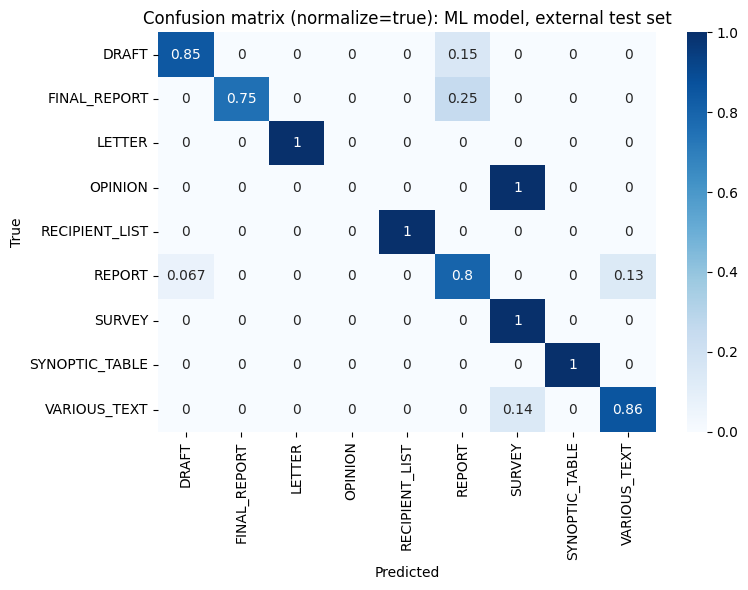

In [43]:
report = sklearn.metrics.classification_report(
    df_test_external["document_type"],
    df_test_external["prediction_ml"],
    zero_division=np.nan,
)
mlflow.log_text(report, "external_test_classification_report.txt")
print(report)

cm = plotting.plot_confusion_matrix_heatmap(
    df_test_external["document_type"],
    df_test_external["prediction_ml"],
    title="ML model, external test set",
    normalize="true",
)
mlflow.log_figure(cm, "external_test_confusion_matrix.png")
display(cm)

## Rule-based model vs. ground truth

                precision    recall  f1-score   support

         DRAFT       0.83      0.83      0.83         6
  FINAL_REPORT       1.00      0.67      0.80         3
        LETTER       1.00      1.00      1.00         7
RECIPIENT_LIST       1.00      0.86      0.92         7
        REPORT       0.90      0.90      0.90        10
        SURVEY       1.00      1.00      1.00         1
SYNOPTIC_TABLE       1.00      0.89      0.94         9
  VARIOUS_TEXT       0.50      1.00      0.67         3

      accuracy                           0.89        46
     macro avg       0.90      0.89      0.88        46
  weighted avg       0.92      0.89      0.90        46



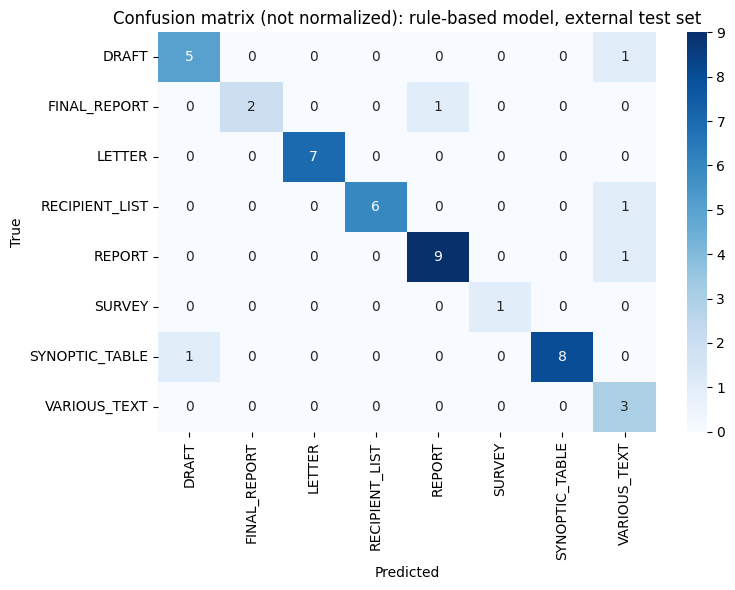

In [44]:
_df = df_test_external[df_test_external["prediction_rule"].notna()]
print(sklearn.metrics.classification_report(_df["document_type"], _df["prediction_rule"], zero_division=np.nan))
plotting.plot_confusion_matrix_heatmap(
    _df["document_type"],
    _df["prediction_rule"],
    title="rule-based model, external test set",
    # normalize="true",
)

***

# End run

In [45]:
# mlflow.sklearn.log_model(
#     classifier_external_test,
#     artifact_path="model",
#     registered_model_name="document_type_classifier",
# )

In [46]:
mlflow.end_run()

🏃 View run shivering-cat-248 at: https://mlflow.ml1.demokratis.ch/#/experiments/2/runs/da68b97bd01b462a8f2a11021e8d145f
🧪 View experiment at: https://mlflow.ml1.demokratis.ch/#/experiments/2
